# Centrica Gas Demand Forecasting

This notebook contains the code developed by Devon Stone for the Centrica Gas Demand Forecasting Challenge, which entailed developing a gas forecasting model capable of accurately predicting total consumption for the UK.  

The code is broken down into four main sections:

1.  Data Exploration and Preprocessing
2.  Data Analysis
3.  Modeling
4.  Results and Further Analysis


### Required Packages

In [0]:
# standard packages
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
# forecasting packages
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
# install Google Drive libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1. Data Exploration and Preprocessing

### Read in data and Drop Duplicates

In [0]:
# consumption data 
con_link = drive.CreateFile({'id':'1jAfHBDy3BP3NbgTe_wRIw7X_cdzrk2k4'}) 
con_link.GetContentFile('DataItems_LDZdemand.csv')
con_data = pd.read_csv('DataItems_LDZdemand.csv').drop_duplicates()

# weather data
cwv_link = drive.CreateFile({'id':'1JrlLWYZQPseInw3yl-EdFhxXVH0XGO3I'}) 
cwv_link.GetContentFile('DataItems_CWV.csv')
cwv_data = pd.read_csv('DataItems_CWV.csv').drop_duplicates()

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [0]:
con_data.head(1)

,Applicable At,Applicable For,Data Item,Value,Generated Time,Quality Indicator
0,05/02/2020 20:47,30/01/2020,"Demand, Actual NDM, LDZ(EA), D+6",157251853,05/02/2020 20:52,L


In [0]:
cwv_data.head(1)

,Applicable At,Applicable For,Data Item,Value,Generated Time,Quality Indicator,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,06/02/2020 11:38,05/02/2020,"Composite Weather Variable, Actual, LDZ(EA), D+1",5.83,06/02/2020 11:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean Columns

In [0]:
# clean column names of white spaces and lower them
con_data.columns = con_data.columns.str.strip().str.replace(' ', '_').str.lower()
cwv_data.columns = cwv_data.columns.str.strip().str.replace(' ', '_').str.lower()
# extract only LDZ code from data item column (pull code from between brackets using regex)
con_data['ldz'] = con_data.data_item.str.extract(r'\((.*?)\)')
cwv_data['ldz'] = cwv_data.data_item.str.extract(r'\((.*?)\)')

### Assess Missing Values in CWV Data

In [0]:
def get_missing_value_perc(df):
    # input: pandas df
    # output: the percetange of missing values in each column
    percent_missing = df.isna().mean().round(4) * 100
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                   'percent_missing': percent_missing
                                  }
    )
    return missing_value_df.reset_index(drop=True)

In [0]:
get_missing_value_perc(cwv_data)

,column_name,percent_missing
0,applicable_at,0.00
1,applicable_for,0.00
2,data_item,0.00
3,value,0.00
4,generated_time,0.00
5,quality_indicator,99.15
6,unnamed:_6,100.00
7,unnamed:_7,100.00
8,unnamed:_8,100.00
9,unnamed:_9,100.00


We can see from the above that the unnamed varibles and the Quality Indicator	are very sparesly populated and as a result we will remove them.

In [0]:
cwv_data = cwv_data[['applicable_at',	'applicable_for',	'data_item', 'value',	'generated_time', 'ldz']]

In [0]:
get_missing_value_perc(con_data)

,column_name,percent_missing
0,applicable_at,0.00
1,applicable_for,0.00
2,data_item,0.00
3,value,0.00
4,generated_time,0.00
5,quality_indicator,4.61
6,ldz,0.00


### Set Index of Consumption Data (Required for Plotting)


In [0]:
con_data = con_data.set_index('applicable_for')
con_data.index = pd.to_datetime(con_data.index)
con_data.value = con_data.value/1000000000

# 2. Data Analysis

### Total Consumption (From 2018)

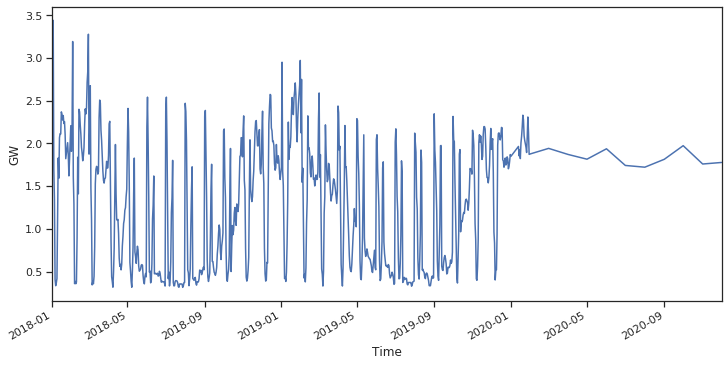

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
# use unstack()
con_data.groupby('applicable_for').sum()['value'].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GW")
plt.show()

The data does not appear to be complete after 2020/01/01, so we will only use data to the point or gather more data from the website.

Another thing we can see from the plot above seasonality of gas consumption. 

In [0]:
con_data = con_data.loc[(con_data.index<'2020-01-01')]

Let's smooth the curve above by resampling

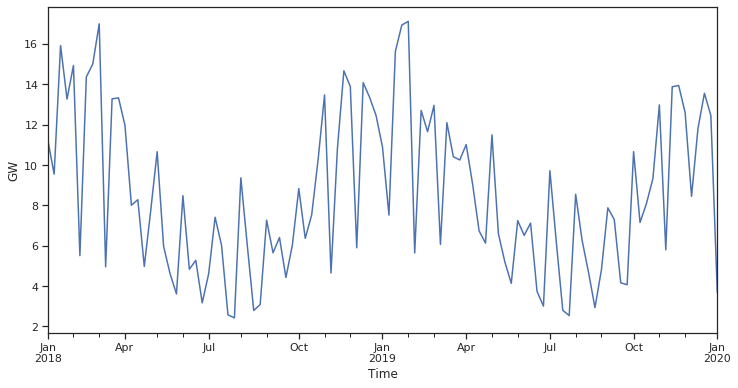

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
# use unstack() and resample to smooth curves
con_data.groupby('applicable_for').sum()['value'].resample('W').sum().plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GW")
plt.show()

### Monthly Consumption by LDZ (From 2018)

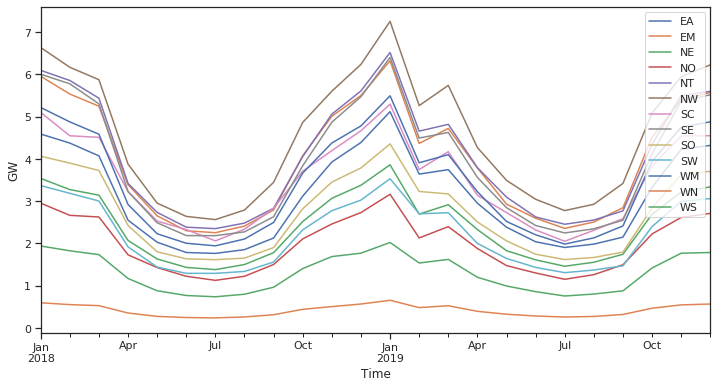

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
# use unstack() and resample to smooth curves
con_data.groupby(['applicable_for','ldz']).sum()['value'].unstack().resample('M').sum().plot(ax=ax)
ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("GW")
plt.show()

We can see seasonailty but not trend. Let's add more data. 

### All Consumption Data from Google Drive Folder

In [0]:
fileList = drive.ListFile({'q': "'1DkntMcuQZhMHjLGG0QLTUKXz4k5XKQ5M' in parents and trashed=false"}).GetList()
df_filelist_id = pd.DataFrame(fileList)
list_ov_id = df_filelist_id['id']

all_con_data = pd.DataFrame()

for i in list_ov_id:
  downloaded = drive.CreateFile({'id':i})
  downloaded.GetContentFile('Filename.csv')
  df_ov = pd.read_csv('Filename.csv')
  all_con_data = pd.DataFrame.append(all_con_data,df_ov,ignore_index=True, sort=True)
  all_con_data.drop_duplicates()

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files?q=%271DkntMcuQZhMHjLGG0QLTUKXz4k5XKQ5M%27+in+parents+and+trashed%3Dfalse&maxResults=1000&alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1-wky4xd-g2h_PbVmU7I4SYWYg6rZR3gM?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1nPoIOCULZ9ZrwgGsfn1wzC15urSFS5g6?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1bKBH31g6vsn02pYUXjb4k7iQSHkEconU?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1bpaJkpUSWzF5rGNcuDCBOXg6bQBePdtA?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1FOcMn7_n79yJ0VLERQ6J6M87F2ZKR2b-?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1

In [0]:
fileList = drive.ListFile({'q': "'1PzWvtEC2wxqlreOA1NVHvmHCdeU1kO8H' in parents and trashed=false"}).GetList()
df_filelist_id = pd.DataFrame(fileList)
list_ov_id = df_filelist_id['id']

all_cwv_data = pd.DataFrame()

for i in list_ov_id:
  downloaded = drive.CreateFile({'id':i})
  downloaded.GetContentFile('Filename.csv')
  df_ov = pd.read_csv('Filename.csv')
  all_cwv_data = pd.DataFrame.append(all_cwv_data,df_ov,ignore_index=True, sort=True)
  all_cwv_data.drop_duplicates()

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files?q=%271PzWvtEC2wxqlreOA1NVHvmHCdeU1kO8H%27+in+parents+and+trashed%3Dfalse&maxResults=1000&alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1oss5hgMEwwkzPLNUVWx_nnhL6b4Nm-hD?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1TSOohmLdT6CnMm72W68qL4j0zF7bycfS?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1EgJHvqdPuMf3NAOwCZ5IfRLdyiM8k-gA?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1IAFUNagCN-eP6B1tcWOyLUeH6SYTuSsV?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/133GRJWHEx2t4h6qfpzr5Q2OsQN7o2QwR?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1

### Clean Columns and Perform Slices Previously Done

In [0]:
# clean column names of white spaces and lower them
all_con_data.columns = all_con_data.columns.str.strip().str.replace(' ', '_').str.lower()
all_cwv_data.columns = all_cwv_data.columns.str.strip().str.replace(' ', '_').str.lower()
# extract only LDZ code from data item column (pull code from between brackets using regex)
all_con_data['ldz'] = all_con_data.data_item.str.extract(r'\((.*?)\)')
all_cwv_data['ldz'] = all_cwv_data.data_item.str.extract(r'\((.*?)\)')

# specific columns for cwv data
all_cwv_data = all_cwv_data[['applicable_at',	'applicable_for',	'data_item', 'value',	'generated_time', 'ldz']]

# set date time indicies
all_con_data = all_con_data.set_index('applicable_for')
all_con_data.index = pd.to_datetime(all_con_data.index)
all_cwv_data = all_cwv_data.set_index('applicable_for')
all_cwv_data.index = pd.to_datetime(all_cwv_data.index)

# cut by date
all_con_data = all_con_data.loc[(all_con_data.index<'2020-02-01')]
all_cwv_data = all_cwv_data.loc[(all_cwv_data.index<'2020-02-01')]

### Total Consumption (from 2015)

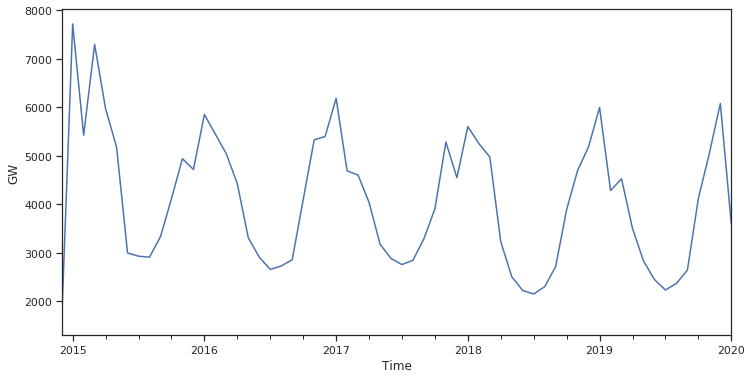

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
# use unstack() and resample to smooth curves
all_con_data.groupby('applicable_for').sum()['value'].resample('M').sum().plot(ax=ax, label='Consumption')
ax.set_xlabel("Time")
ax.set_ylabel("GW")
plt.show()

### Monthly Consumption by LDZ (From 2015)

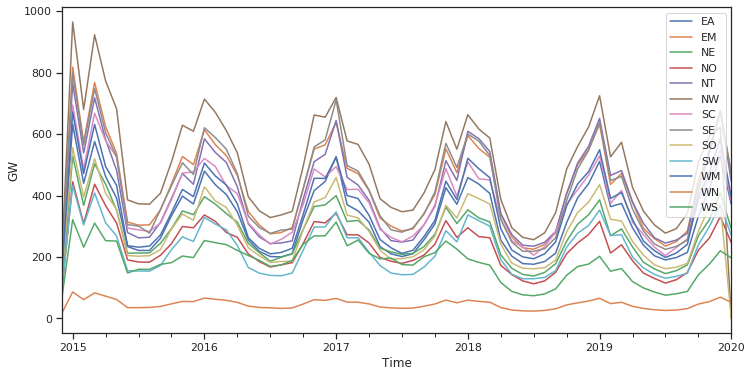

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
# use unstack() and resample to smooth curves
all_con_data.groupby(['applicable_for','ldz']).sum()['value'].unstack().resample('M').sum().plot(ax=ax)
ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("GW")
plt.show()

### Merge Consumption and CWV

In [0]:
df_final = pd.merge(all_con_data, all_cwv_data, how='inner', left_index=True, right_index=True)
df_final = df_final[df_final['ldz_x']==df_final['ldz_y']]
df_final = df_final[['value_x', 'value_y']]
df_final = df_final.rename(columns={"value_x": "Consumption", "value_y": "CWV"})
df_final = df_final.groupby(['applicable_for']).agg({'Consumption': np.sum, 'CWV': np.mean})

### CWV vs Consumption (From 2015)

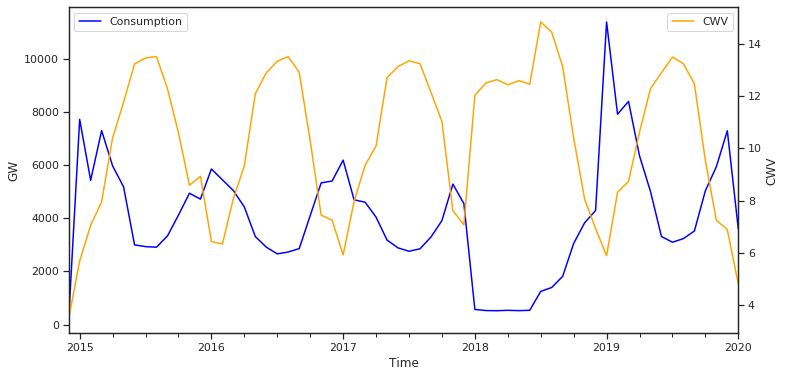

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
# use unstack() and resample to smooth curves
plot_df = df_final.resample('M').agg({'Consumption': np.sum, 'CWV': np.mean})
plot_df.Consumption.plot(ax=ax, color='blue', label='Consumption')
ax2=ax.twinx()
plot_df.CWV.plot(ax=ax2, color='orange', label='CWV')
ax.legend(loc=2)
ax2.legend(loc=0)
ax.set_xlabel("Time")
ax.set_ylabel("GW")
ax2.set_ylabel("CWV")
plt.show()

### Explore Consumption and CWV

To get a further impression about consumption and CWV in the data we can plot ECDF and a scatter plot.

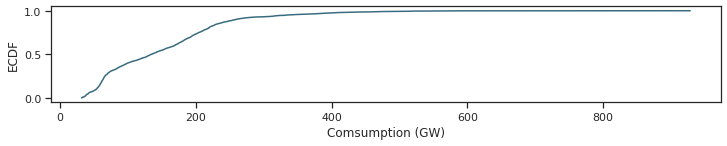

In [0]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))
plt.subplot(311)
cdf = ECDF(df_final['Consumption'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Comsumption (GW)')
plt.ylabel('ECDF')
plt.show()

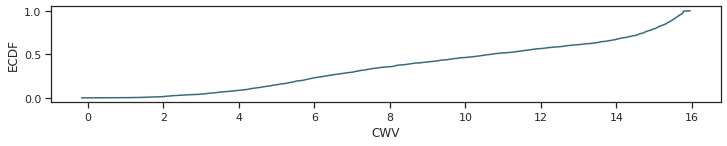

In [0]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))
# plot second ECDF  
plt.subplot(312)
cdf = ECDF(df_final['CWV'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('CWV')
plt.ylabel('ECDF')
plt.show()

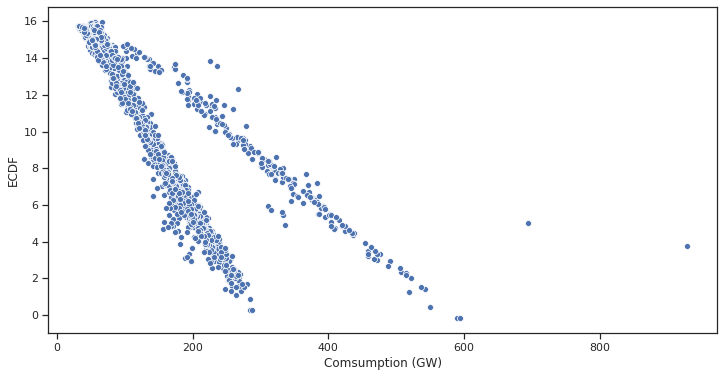

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.scatterplot(x="Consumption", y="CWV", data=df_final)
plt.xlabel('Comsumption (GW)')
plt.ylabel('ECDF')
plt.show()

### Remove Seasonality to Assess Trend

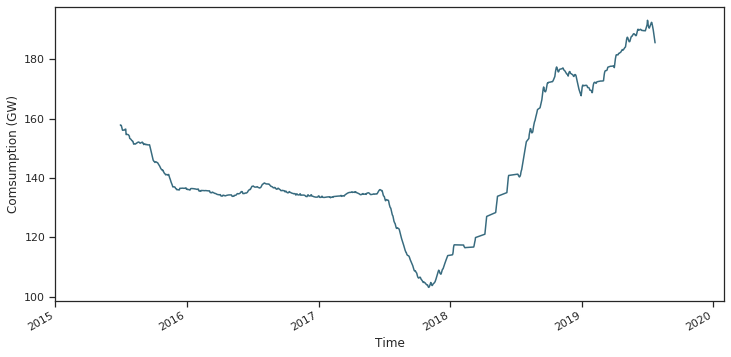

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
decomposition_a = seasonal_decompose(df_final.Consumption, model = 'additive', freq=365)
decomposition_a.trend.plot(color = c, ax = ax)
plt.xlabel('Time')
plt.ylabel('Comsumption (GW)')
plt.show()

From the above image there does not appear to be a trend in terms of increasing of decreasing total gas consumption over the last 5 years.

### Autocorrelaion

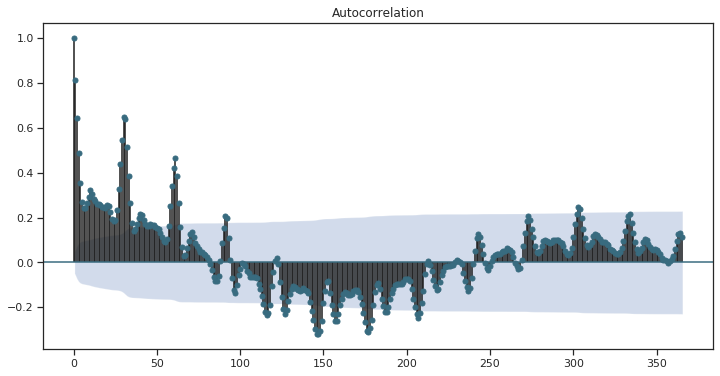

In [0]:
# figure for subplots
fig, ax = plt.subplots(figsize=(12,6))
# acf
plot_acf(df_final.Consumption, ax = plt.gca(),lags=365, color = c)
plt.show()

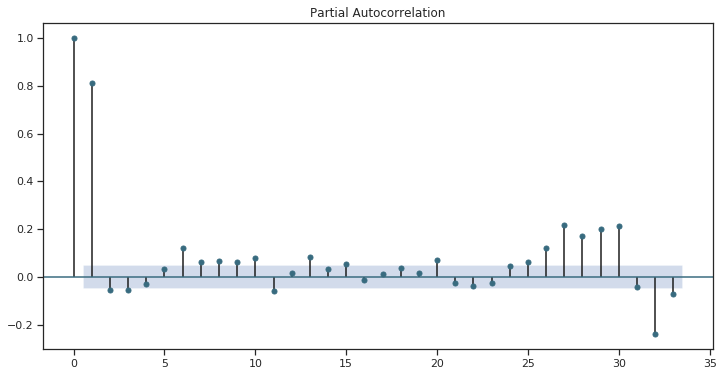

In [0]:
# figure for subplots
fig, ax = plt.subplots(figsize=(12,6))
# pacf
plot_pacf(df_final.Consumption, ax = plt.gca(), color = c)
plt.show()

# 3. Modeling

### Train/Test Split

In [0]:
# change column names for Prophet
df_model = df_final
df_model['ds'] = df_model.index
df_model = df_model.reset_index(inplace=False)
df_model = df_model[['Consumption','CWV',	'ds']]
df_model = df_model.rename(columns={"Consumption": "y", "ds": "ds"})

In [0]:
df_train = df_model.loc[df_model['ds']<'2019-12-02']
df_test = df_model.loc[df_model['ds']>='2019-12-02']
#df_train = df_model[:int(len(df_model)*0.8)]
#df_test = df_model[int(len(df_model)*0.8):]

### Fit Model

In [0]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model = Prophet( growth='linear',
                seasonality_mode='additive',
                daily_seasonality=False,
                changepoint_prior_scale=10,
                weekly_seasonality=False,

)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=10)
model.add_regressor('CWV', mode='additive')
model.fit(df_train)

### Make  Predictions

In [0]:
futures = model.predict(df_test)
train_forecast = model.predict(df_train)

# 4. Results and Further Analysis

### Forecast

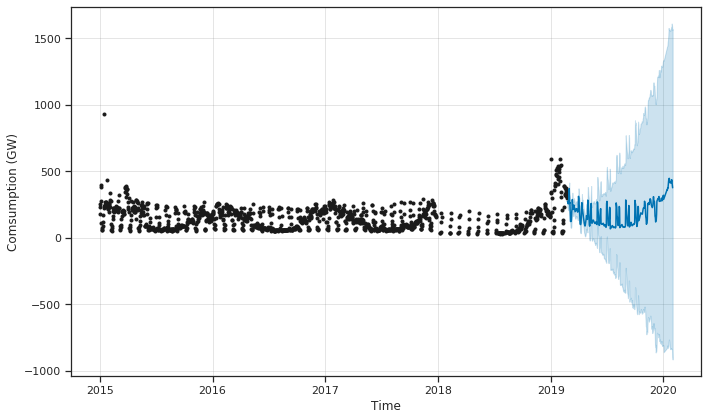

In [0]:
model.plot(futures)
plt.xlabel('Time')
plt.ylabel('Comsumption (GW)')
plt.show()

### Components

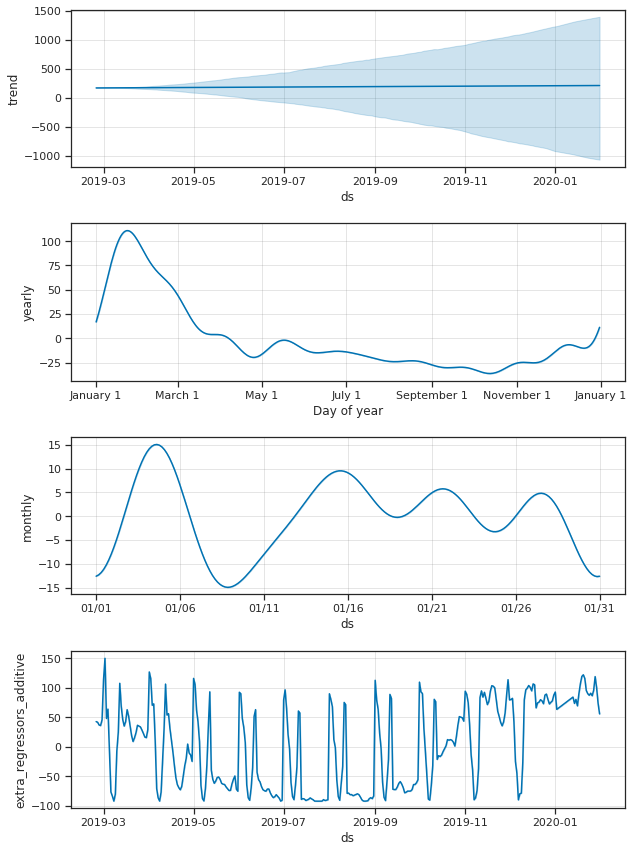

In [0]:
model.plot_components(futures)
plt.show()

### Accuracy

In [0]:
def make_comp_df(actuals, forecast):
  # input: pandas dfs containing actuals and forecasts respcetively
  # output: pandas df containing both acutals and forecast values
  return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(actuals.set_index('ds'))

def forecast_errors(df):
  # input: pandas test df and length of predicitons
  # output: mean absolute error
  df = df.copy()

  df['e'] = np.abs(df['y'] - df['yhat'])
  df['p'] = 100 * df['e']/df['y']

  mae = round(df.e.sum()/len(df),2)
  mape = round(df.p.sum()/len(df),2)

  print("MAPE is {MAPE} percent".format(MAPE = str(mape)))
  print("MAE is {MAE}".format(MAE = str(mae)))

### Training Accuracy

In [0]:
cmp_df = make_comp_df(df_train, train_forecast)
cmp_df = cmp_df.loc[cmp_df['y'].notnull()]
forecast_errors(cmp_df)

MAPE is 15.96 percent
MAE is 20.48


### Test Accuracy

In [0]:
cmp_df_test = make_comp_df(df_test, futures)
cmp_df_test = cmp_df_test.loc[cmp_df_test['y'].notnull()]
forecast_errors(cmp_df_test)

MAPE is 61.98 percent
MAE is 76.66
